# 0. Install Dependencies and Bring in Data

In [2]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn


[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.tail()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik
6990,Mas. Sebenarnya aku gamau bully mas tp kek nya...,instagram,0,0,0,0
6991,"Kdang ngaku nicky minaj, kdang beyonce, kdang ...",instagram,0,0,0,0
6992,"Time kemas sesuatu tadi, terfikir jugak botol ...",twitter,0,0,1,0
6993,"@BasherRL heh kontol, jan sok pemes lu di rp, ...",twitter,1,0,0,1
6994,"Maen bacok""an yuk""QueenMutiaa: Kalau kamu suka...",twitter,0,1,1,1


# 1. Preprocess

In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['original_text'] # kolom original text
y = df[df.columns[2:]].values # kolom output

In [8]:
def remove_newline(text):
    return re.sub('\n', ' ',text)

def remove_kaskus_formatting(text):
    text = re.sub('\[', ' [', text)
    text = re.sub('\]', '] ', text)
    text = re.sub('\[quote[^ ]*\].*?\[\/quote\]', ' ', text)
    text = re.sub('\[[^ ]*\]', ' ', text)
    text = re.sub('&quot;', ' ', text)
    return text

def remove_url(text):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)

def remove_excessive_whitespace(text):
    return re.sub('  +', ' ', text)

from nltk.tokenize import WordPunctTokenizer

import re

def tokenize_text(text, punct=False):
    text = WordPunctTokenizer().tokenize(text)
    text = [word for word in text if punct or word.isalnum()]
    text = ' '.join(text)
    text = text.strip()
    return text

def remove_non_alphabet(text):
    output = re.sub('[^a-zA-Z ]+', '', text)
    return output

def remove_twitter_ig_formatting(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'\brt\b', '', text)
    return text

import itertools

slang_words = pd.read_csv('slangword.csv')
slang_dict = dict(zip(slang_words['original'],slang_words['translated']))

def transform_slang_words(text):
    word_list = text.split()
    word_list_len = len(word_list)
    transformed_word_list = []
    i = 0
    while i < word_list_len:
        if (i + 1) < word_list_len:
            two_words = ' '.join(word_list[i:i+2])
            if two_words in slang_dict:
                transformed_word_list.append(slang_dict[two_words])
                i += 2
                continue
        transformed_word_list.append(slang_dict.get(word_list[i], word_list[i]))
        i += 1
    return ' '.join(transformed_word_list)

def remove_repeating_characters(text):
    return ''.join(''.join(s)[:1] for _, s in itertools.groupby(text))

In [9]:
def preprocess_text(text):
    transformed_text = text.lower()
    transformed_text = remove_newline(text)
    transformed_text = remove_url(transformed_text)
    transformed_text = remove_twitter_ig_formatting(transformed_text)
    transformed_text = remove_kaskus_formatting(transformed_text)
    transformed_text = transformed_text.lower()
    transformed_text = tokenize_text(transformed_text)
    transformed_text = transform_slang_words(transformed_text)
    transformed_text = remove_repeating_characters(transformed_text)
    transformed_text = transform_slang_words(transformed_text)
    transformed_text = remove_non_alphabet(transformed_text)
    transformed_text = remove_excessive_whitespace(transformed_text)
    transformed_text = transformed_text.lower().strip()
    return transformed_text

In [10]:
X = X.apply(preprocess_text)
# len(X)

In [11]:
# membatasi jumlah kata yang ditokenize
MAX_FEATURES = 200000 # number of words in the vocab

In [12]:
# output_sequence_length : membatasi panjang kata di kalimat

vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [13]:
vectorizer.adapt(X.values)

In [14]:
vectorized_text = vectorizer(X.values)

In [15]:
# menyiapkan dataset untuk dipakai
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16) 
dataset = dataset.prefetch(8) 

In [16]:
train = dataset.take(int(len(dataset)*0.7)) # 70% dari dataset dijadikan train dataset
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2)) # 20% jadi validation dataset
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1)) # 10% jadi dataset

# 2. Create Sequential Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [18]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
# Final layer 
model.add(Dense(4, activation='sigmoid'))

In [19]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                        

In [21]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
306/306 [==============================] - 420s 1s/step - loss: 0.4492 - val_loss: 0.3350
Epoch 2/5
306/306 [==============================] - 448s 1s/step - loss: 0.2947 - val_loss: 0.2330
Epoch 3/5
306/306 [==============================] - 321s 1s/step - loss: 0.2173 - val_loss: 0.1739
Epoch 4/5
306/306 [==============================] - 267s 873ms/step - loss: 0.1581 - val_loss: 0.1142
Epoch 5/5
306/306 [==============================] - 373s 1s/step - loss: 0.1263 - val_loss: 0.1036


In [36]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

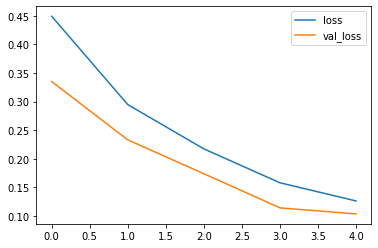

In [37]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [110]:

# string = 'Bego kalau masih berfikir ,harus angkat senjata untuk dirikan #khilafah !!'
string =  "heh kontol, jan sok pemes lu di rp, muka kek memek, org tua lu kek monyet, agama lu aje agama kontol"
# string = 'anak monyet tolol'

input_text = vectorizer(string)

In [111]:
res = model.predict(np.array([input_text]))

1/1 [==============================] - 0s 86ms/step


In [113]:
res #hasil model yg telah melewati embbedding, lstm, hidden layer, terus in outputnya (ada  4)

array([[9.9962050e-01, 2.3377757e-03, 1.6778786e-05, 9.8415494e-01]],
      dtype=float32)

In [115]:
np.sum(res)

1.98613

In [114]:
(res > 0.5).astype(int)

array([[1, 0, 0, 1]])

In [104]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text +='{}: {}, '.format(col, results[0][idx]>0.5)
    
    return text

score_comment(string)

1/1 [==============================] - 0s 122ms/step


'pornografi: False, sara: False, radikalisme: False, pencemaran_nama_baik: True, '

In [43]:
res.shape

(1, 4)

In [105]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [107]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 157ms/step


array([[0, 0, 0, 0],
       [0, 1, 1, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [0, 0, 0, 0]])

# 4. Evaluate Model

In [32]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
# untuk mengevaluasi model yang telah kita buat, kita menghitung presisi,recall, akurasi 
# categorical accuracy : (sama seperti akurasi, namun digunakan untuk one hot labels (label nya lebih dari satu, 
# misalnya berbentuk array) ) keakuratan setiap kolom, berisi 0 atau 1

In [33]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [34]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 317ms/step


In [35]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9358108043670654, Recall:0.9111841917037964, Accuracy:0.023255813866853714
